10/30/20

In [4]:
from os import walk
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import random

In [7]:
# setting the root directories and categories of the images
root_dir = './images_background/'
# root_dir = './images_evaluation/'
categories = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]

In [8]:
# creating the pairs of images for inputs, same character label = 1, vice versa
class OmniglotDataset(Dataset):
    
    def __init__(self, categories, root_dir, setSize, transform=None):
        self.categories = categories
        self.root_dir = root_dir
        self.transform = transform
        self.setSize = setSize
    
    def __len__(self):
        return self.setSize

    def __getitem__(self, idx):
        img1 = None
        img2 = None
        label = None
        
        if idx % 2 == 0: # select two examples of the same character
            category = random.choice(categories)  # a category is the alphabet
            character = random.choice(category[1])  # character is the character, so the english alphabet has 26 characters
            
            # pick two random examples of a given character in this alphabet
            imgDir = root_dir + category[0] + '/' + character  
            img1Name = random.choice(os.listdir(imgDir))
            img2Name = random.choice(os.listdir(imgDir))
            img1 = Image.open(imgDir + '/' + img1Name)
            img2 = Image.open(imgDir + '/' + img2Name)

            label = 1.0
            
        else: # select a different character for both images
            category1, category2 = random.choice(categories), random.choice(categories)
            character1, character2 = random.choice(category1[1]), random.choice(category2[1])
            imgDir1, imgDir2 = root_dir + category1[0] + '/' + character1, root_dir + category2[0] + '/' + character2
            img1Name = random.choice(os.listdir(imgDir1))
            img2Name = random.choice(os.listdir(imgDir2))
            while img1Name == img2Name:
                img2Name = random.choice(os.listdir(imgDir2))
            label = 0.0
            img1 = Image.open(imgDir1 + '/' + img1Name)
            img2 = Image.open(imgDir2 + '/' + img2Name)
#         plt.imshow(img1)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))          


In [9]:
# creates n-way one shot learning evaluation
class NWayOneShotEvalSet(Dataset):
    def __init__(self, categories, root_dir, setSize, numWay, transform=None):
        self.categories = categories
        self.root_dir = root_dir
        self.setSize = setSize
        self.numWay = numWay
        self.transform = transform
    def __len__(self):
        return self.setSize

    def __getitem__(self, idx):
        # find one main image
        category = random.choice(categories)  # which alphabet do we want to go with
        character = random.choice(category[1])  # which letter/character in the alphabet do we want to look at
        imgDir = root_dir + category[0] + '/' + character  # now we've decided on a specific letter in a specific alphabet
        imgName = random.choice(os.listdir(imgDir))  # randomly choose an exammple as our main image
        mainImg = Image.open(imgDir + '/' + imgName)

        if self.transform:
            mainImg = self.transform(mainImg)
        
        # find n numbers of distinct images, 1 in the same set as the main
        testSet = []  # the main image is compared against this list of TestSet
        label = np.random.randint(self.numWay)  # numway represents number of alphabets we want to compare to
        
        for i in range(self.numWay):  # how many examples (each example is a unique alphabet) do we get to use
            testImgDir = imgDir
            testImgName = ''
            
            # we want at least one example from the same letter of the same alphabet in the testset
            if i == label:  
                testImgName = random.choice(os.listdir(imgDir))
            
            # all other examples should come from other alphabets/characters
            else:
                testCategory = random.choice(categories)  # now we choose another random category
                testCharacter = random.choice(testCategory[1])  # with another random letter from that alphabet
                testImgDir = root_dir + testCategory[0] + '/' + testCharacter
                while testImgDir == imgDir:
                    testImgDir = root_dir + testCategory[0] + '/' + testCharacter
                testImgName = random.choice(os.listdir(testImgDir))  # with a random example
            
            testImg = Image.open(testImgDir + '/' + testImgName)
            
            if self.transform:
                testImg = self.transform(testImg)
            
            testSet.append(testImg)
        # plt.imshow()
        return mainImg, testSet, torch.from_numpy(np.array([label], dtype = int))

In [10]:
# choose a training dataset size and further divide it into train and validation set 80:20
dataSize = 10000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

transformations = transforms.Compose([transforms.ToTensor()]) 

omniglotDataset = OmniglotDataset(categories, root_dir, dataSize, transformations)
train_set, val_set = random_split(omniglotDataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, num_workers=16)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=16, shuffle=True)

In [11]:
# create the test set for final testing
testSize = 5000 
numWay = 20  # how many alphabets? the more unseen alphabets, the more difficult it is to match examples
test_set = NWayOneShotEvalSet(categories, root_dir, testSize, numWay, transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 2, shuffle=True)


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


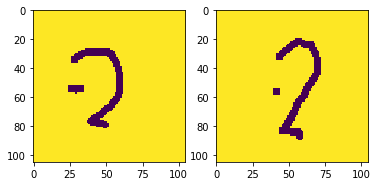

In [12]:
# showing a sample input of a training set
for img1, img2, label in train_loader:
    print()
    if label[0] == 1.0:
        print(img1[0])
        plt.subplot(1,2,1)
        plt.imshow(img1[0][0])
        plt.subplot(1,2,2)
        plt.imshow(img2[0][0])
        # print(label)
        break
    # break

torch.Size([1, 1, 105, 105])


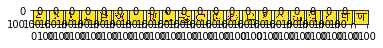

In [13]:
# showing a sample input of the testing set
count = 0
for mainImg, imgset, label in test_loader:
    # print(len(imgset))
    # print(label)
    # print(imgset.shape)
    if label != 1:
        for count, img in enumerate(imgset):
          plt.subplot(1, len(imgset)+1, count+1)
          plt.imshow(img[0][0])
          # print(img.shape)
        print(mainImg.shape)
        plt.subplot(1, len(imgset)+1, len(imgset)+1)
        plt.imshow(mainImg[0][0])
        count += 1
        break
    # break

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Koch et al.
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10)  # go from a single channel to 64 channels
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    
    def convs(self, x):

        # Koch et al.
        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))  # starting with 1x105x105 image, x becomes 64x96x96
        x = F.max_pool2d(x, (2,2))  # 64x96x96 turns into 64x48x48
        x = F.relu(self.bn2(self.conv2(x)))  #64x48x48 turns into 128x42x42
        x = F.max_pool2d(x, (2,2))  # 128x42x42 turns into 128x21x21
        x = F.relu(self.bn3(self.conv3(x)))  # 128x21x21 turns into 128x18x18
        x = F.max_pool2d(x, (2,2))  # 128x18x18 turns into 128x9x9
        x = F.relu(self.bn4(self.conv4(x)))  # 128x9x9 turns into 256x6x6
        return x
    

    def forward(self, x1, x2):
        x1 = self.convs(x1)

        # Koch et al.
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))
        
        x2 = self.convs(x2)  # notice we use the same network
        x2 = x2.view(-1, 256 * 6 * 6)
        x2 = self.sigmoid(self.fc1(x2))

        # the outputs for img1 and img2 are "merged" by taking the absolute difference
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [16]:
#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseBaseLine = Net()
siameseBaseLine = siameseBaseLine.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseBaseLine)

The model architecture:

 Net(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fcOut): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 38,952,897 trainable parameters


In [17]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [18]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    
    for epoch in range(num_epochs):  # number of passes through training dataset
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()  # switch to eval() since there are dropout and batchnorm layers in the model
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'.format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  

# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for mainImg, imgSets, label in test_loader:
            mainImg = mainImg.to(device)
            predVal = 0
            pred = -1
            
            # go through each image in testsets (there are 20), lets find the image with the highest similarity
            for i, testImg in enumerate(imgSets):
                testImg = testImg.to(device)
                output = model(mainImg, testImg)
                if output > predVal:
                    pred = i
                    predVal = output
            label = label.to(device)
            if pred == label:
                correct += 1
            count += 1
            if count % 20 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(correct/count))



In [ ]:
# actual training
import torch.optim as optim

optimizer = optim.Adam(siameseBaseLine.parameters(), lr = 0.0006)
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()
save_path = 'siameseNet-batchnorm50.pt'
train_losses, val_losses = train(siameseBaseLine, train_loader, val_loader, num_epochs, criterion, save_path)

Starting epoch 1


In [ ]:
# Evaluation on previously saved models
import torch.optim as optim
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0006)


num_epochs = 10
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer)

print(best_val_loss)
eval(load_model, test_loader)

Model loaded from <== siameseNet-batchnorm50.pt
0.06619010965561553
Starting Iteration
Current Count is: 20
Accuracy on n way: 0.75
Current Count is: 40
Accuracy on n way: 0.8


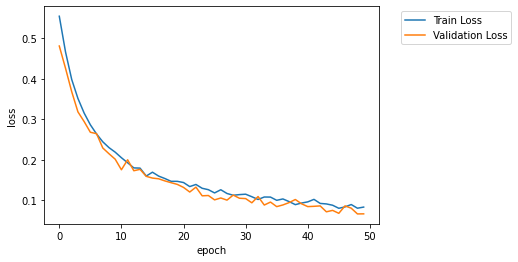

In [ ]:
#plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


In [ ]:
"""How to use the evaluation n way:

# Set the parameters
testSize = 5000 # how big you want your test size to be
numWay = 4 # how many ways metric

# Create the dataset for it and put it into dataloader
test_set = NWayOneShotEvalSet(categories, root_dir, testSize, numWay, transformations) 
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 2)


# Load the models (the name of the loaded model can be changed in the load_checkpoint() function)
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0006)


num_epochs = 10
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer)

print(best_val_loss)

# Evaluate from the test loader 

eval(load_model, test_loader)

"""